# Project 1: Census Data Analysis & Choropleth Mapping

**Geospatial Data Analysis Tutorial - Phase 1**

Welcome to Project 1! Building on the mapping fundamentals from Project 0, we'll now dive into **demographic data analysis** and **choropleth mapping** using real US Census data.

## 🎯 Learning Objectives

By the end of this notebook, you will:
- Master US Census data acquisition and processing
- Create professional choropleth maps showing demographic patterns
- Perform statistical analysis of population demographics
- Understand data classification methods for mapping
- Build interactive visualizations with multiple data layers
- Apply geospatial joins and data integration techniques

## 📊 What We'll Analyze

1. **Census API Setup** - Access live Census data programmatically
2. **State-Level Analysis** - Population, income, and demographic patterns
3. **County-Level Deep Dive** - Detailed choropleth mapping
4. **Statistical Analysis** - Correlation, clustering, and spatial patterns
5. **Advanced Choropleth Design** - Classification schemes and color theory
6. **Interactive Maps** - Multi-variable visualization techniques

## 🗺️ Key Datasets

- **US Census Bureau**: American Community Survey (ACS) 5-year estimates
- **Census TIGER/Line**: Administrative boundaries (states, counties)
- **Demographics**: Population, income, education, housing data

Let's begin exploring the demographic landscape of America! 🇺🇸

## 1. Environment Setup & Library Imports

First, let's import all the required libraries for Census data analysis and choropleth mapping. We'll use the Census API for live data access.

In [2]:
# Core geospatial and data analysis libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

# Census data access
import requests
import json
from urllib.parse import urlencode

# Utility libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up high-quality plotting
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("✅ All libraries imported successfully!")
print(f"GeoPandas version: {gpd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Python version: {sys.version.split()[0]}")

# Setup project paths
project_root = Path('..')
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
outputs_dir = project_root / 'outputs'
figures_dir = outputs_dir / 'figures'

# Create directories if they don't exist
for directory in [raw_data_dir, processed_data_dir, figures_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Project directories ready!")
print(f"   Data: {data_dir}")
print(f"   Outputs: {figures_dir}")

✅ All libraries imported successfully!
GeoPandas version: 1.1.1
Pandas version: 2.3.1
Matplotlib version: 3.10.5
Python version: 3.11.6
📁 Project directories ready!
   Data: ../data
   Outputs: ../outputs/figures


## 2. US Census API Setup & Data Access

The US Census Bureau provides free access to demographic data through their API. We'll access the **American Community Survey (ACS) 5-year estimates**, which provides reliable demographic data at state and county levels.

**Key Census Datasets:**
- **ACS 5-Year**: Most detailed demographic data (population, income, education, housing)
- **TIGER/Line**: Boundary files for states, counties, census tracts
- **Decennial Census**: Population counts every 10 years

We'll start by setting up our data access functions and getting state-level population data.

In [3]:
# Census API Configuration
CENSUS_BASE_URL = "https://api.census.gov/data"
CENSUS_YEAR = "2022"  # Using 2022 ACS 5-year estimates (latest available)

def fetch_census_data(variables, geography, state="*", county="*", year=CENSUS_YEAR):
    """
    Fetch data from US Census API
    
    Parameters:
    - variables: dict of {variable_code: descriptive_name}
    - geography: geographic level ('state', 'county')
    - state: state code ('*' for all states, '06' for CA, etc.)
    - county: county code ('*' for all counties)
    """
    
    # Build the API URL
    dataset = f"{CENSUS_BASE_URL}/{year}/acs/acs5"
    
    # Prepare variables string
    get_vars = ",".join(variables.keys())
    
    # Build geography parameter
    if geography == 'state':
        for_geo = "state:*"
    elif geography == 'county':
        if state == "*":
            for_geo = "county:*"
        else:
            for_geo = f"county:*&in=state:{state}"
    
    # Make the API request
    params = {
        'get': get_vars,
        'for': for_geo
    }
    
    try:
        response = requests.get(dataset, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        # Convert to DataFrame
        df = pd.DataFrame(data[1:], columns=data[0])  # First row is headers
        
        # Rename columns to descriptive names
        rename_dict = {code: name for code, name in variables.items()}
        df = df.rename(columns=rename_dict)
        
        # Convert numeric columns
        for col in rename_dict.values():
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        print(f"✅ Fetched {len(df)} {geography} records")
        return df
        
    except Exception as e:
        print(f"❌ Error fetching Census data: {e}")
        return None

# Define key demographic variables we'll analyze
state_variables = {
    'B01003_001E': 'total_population',      # Total population
    'B19013_001E': 'median_household_income', # Median household income
    'B25001_001E': 'total_housing_units',   # Total housing units
    'B08303_001E': 'total_commuters',       # Total commuters
    'B15003_022E': 'bachelors_degree',      # Bachelor's degree or higher
    'B08006_008E': 'work_from_home',        # Work from home
}

print("📊 Fetching state-level demographic data...")
state_data = fetch_census_data(state_variables, 'state')

if state_data is not None:
    print(f"\n📈 State Data Preview:")
    print(f"   Shape: {state_data.shape}")
    print(f"   Columns: {', '.join(state_data.columns)}")
    
    # Display top 5 most populous states
    top_states = state_data.nlargest(5, 'total_population')[['state', 'total_population', 'median_household_income']]
    print(f"\n🏆 Top 5 Most Populous States:")
    for _, row in top_states.iterrows():
        print(f"   State {row['state']}: {row['total_population']:,} people, ${row['median_household_income']:,} median income")
else:
    print("❌ Failed to fetch state data")

📊 Fetching state-level demographic data...
✅ Fetched 52 state records

📈 State Data Preview:
   Shape: (52, 7)
   Columns: total_population, median_household_income, total_housing_units, total_commuters, bachelors_degree, work_from_home, state

🏆 Top 5 Most Populous States:
   State 06: 39,356,104 people, $91,905 median income
   State 48: 29,243,342 people, $73,035 median income
   State 12: 21,634,529 people, $67,917 median income
   State 36: 19,994,379 people, $81,386 median income
   State 42: 12,989,208 people, $73,170 median income
✅ Fetched 52 state records

📈 State Data Preview:
   Shape: (52, 7)
   Columns: total_population, median_household_income, total_housing_units, total_commuters, bachelors_degree, work_from_home, state

🏆 Top 5 Most Populous States:
   State 06: 39,356,104 people, $91,905 median income
   State 48: 29,243,342 people, $73,035 median income
   State 12: 21,634,529 people, $67,917 median income
   State 36: 19,994,379 people, $81,386 median income
   Stat

## 3. Load Geographic Boundaries & Create GeoDataFrame

Now we'll load the state boundaries from Census TIGER/Line files and merge them with our demographic data to create our first choropleth maps.

In [8]:
# Load US States boundaries from Census TIGER/Line (2022)
states_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"

print("📦 Loading US States boundaries...")

# Function to check file size (reusing from previous project)
def check_file_size(url, max_size_mb=100):
    """Check if file size is within acceptable limits before downloading"""
    try:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        
        response = requests.head(url, timeout=10, verify=False)
        if 'content-length' in response.headers:
            size_bytes = int(response.headers['content-length'])
            size_mb = size_bytes / (1024 * 1024)
            return size_mb, size_mb <= max_size_mb
        else:
            return None, True
    except Exception as e:
        print(f"❌ Could not check size: {e}")
        return None, False

# Check file size and load
size_mb, is_safe = check_file_size(states_url, 50)  # 50MB limit for boundaries
if size_mb:
    print(f"   File size: {size_mb:.1f}MB")

if is_safe:
    try:
        # GeoPandas can read directly from ZIP URLs
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        
        states_gdf = gpd.read_file(states_url)
        print(f"✅ Loaded {len(states_gdf)} state boundaries")
        print(f"   CRS: {states_gdf.crs}")
        print(f"   Columns: {', '.join(states_gdf.columns[:5])}...")
    except Exception as e:
        print(f"❌ Error loading states: {e}")
        states_gdf = None
else:
    print(f"❌ File too large (>{50}MB), skipping")
    states_gdf = None

# Check if both required datasets are available before proceeding
if states_gdf is not None and state_data is not None:
    # Clean up the data - keep only continental US + Alaska + Hawaii 
    # Remove territories (Puerto Rico, etc.)
    continental_states = states_gdf[~states_gdf['STUSPS'].isin(['PR', 'VI', 'AS', 'GU', 'MP'])]
    
    print(f"\n🗺️  Filtered to {len(continental_states)} states + DC")
    
    # Create state FIPS lookup for merging with Census data
    state_fips_lookup = continental_states[['STATEFP', 'STUSPS', 'NAME']].copy()
    print(f"   Sample FIPS codes: {dict(zip(state_fips_lookup['STATEFP'][:3], state_fips_lookup['STUSPS'][:3]))}")
    
    # Merge Census data with geographic boundaries
    # Convert state FIPS to match Census data format
    state_data['STATEFP'] = state_data['state'].astype(str).str.zfill(2)
    
    # Merge demographics with boundaries
    states_with_data = continental_states.merge(
        state_data, 
        on='STATEFP', 
        how='inner'
    )
    
    print(f"\n✅ Successfully merged data for {len(states_with_data)} states")
    print(f"   Final columns: {len(states_with_data.columns)} total")
    
    # Quick preview of merged data
    preview_cols = ['NAME', 'total_population', 'median_household_income']
    print(f"\n📊 Sample merged data:")
    print(states_with_data[preview_cols].head())
    
elif states_gdf is None:
    print("❌ Cannot proceed: Failed to load state boundaries")
    states_with_data = None
elif state_data is None:
    print("❌ Cannot proceed: No Census data available")
    states_with_data = None
else:
    print("❌ Cannot proceed: Missing required data")
    states_with_data = None

📦 Loading US States boundaries...
   File size: 0.2MB
✅ Loaded 52 state boundaries
   CRS: EPSG:4269
   Columns: STATEFP, STATENS, AFFGEOID, GEOID, STUSPS...

🗺️  Filtered to 51 states + DC
   Sample FIPS codes: {'48': 'TX', '06': 'CA', '21': 'KY'}

✅ Successfully merged data for 51 states
   Final columns: 17 total

📊 Sample merged data:
         NAME  total_population  median_household_income
0       Texas          29243342                    73035
1  California          39356104                    91905
2    Kentucky           4502935                    60183
3     Georgia          10722325                    71355
4   Wisconsin           5882128                    72458


## 4. Create Professional Choropleth Maps

Choropleth maps use colors to show how statistical values vary across geographic areas. Let's create professional choropleth maps showing demographic patterns across US states.

**Key Design Principles:**
- **Color schemes**: Sequential (low→high), diverging (negative↔positive), qualitative (categories)
- **Classification**: How to group continuous data (natural breaks, quantiles, equal intervals)
- **Legend**: Clear interpretation guide
- **Context**: Labels, titles, data sources

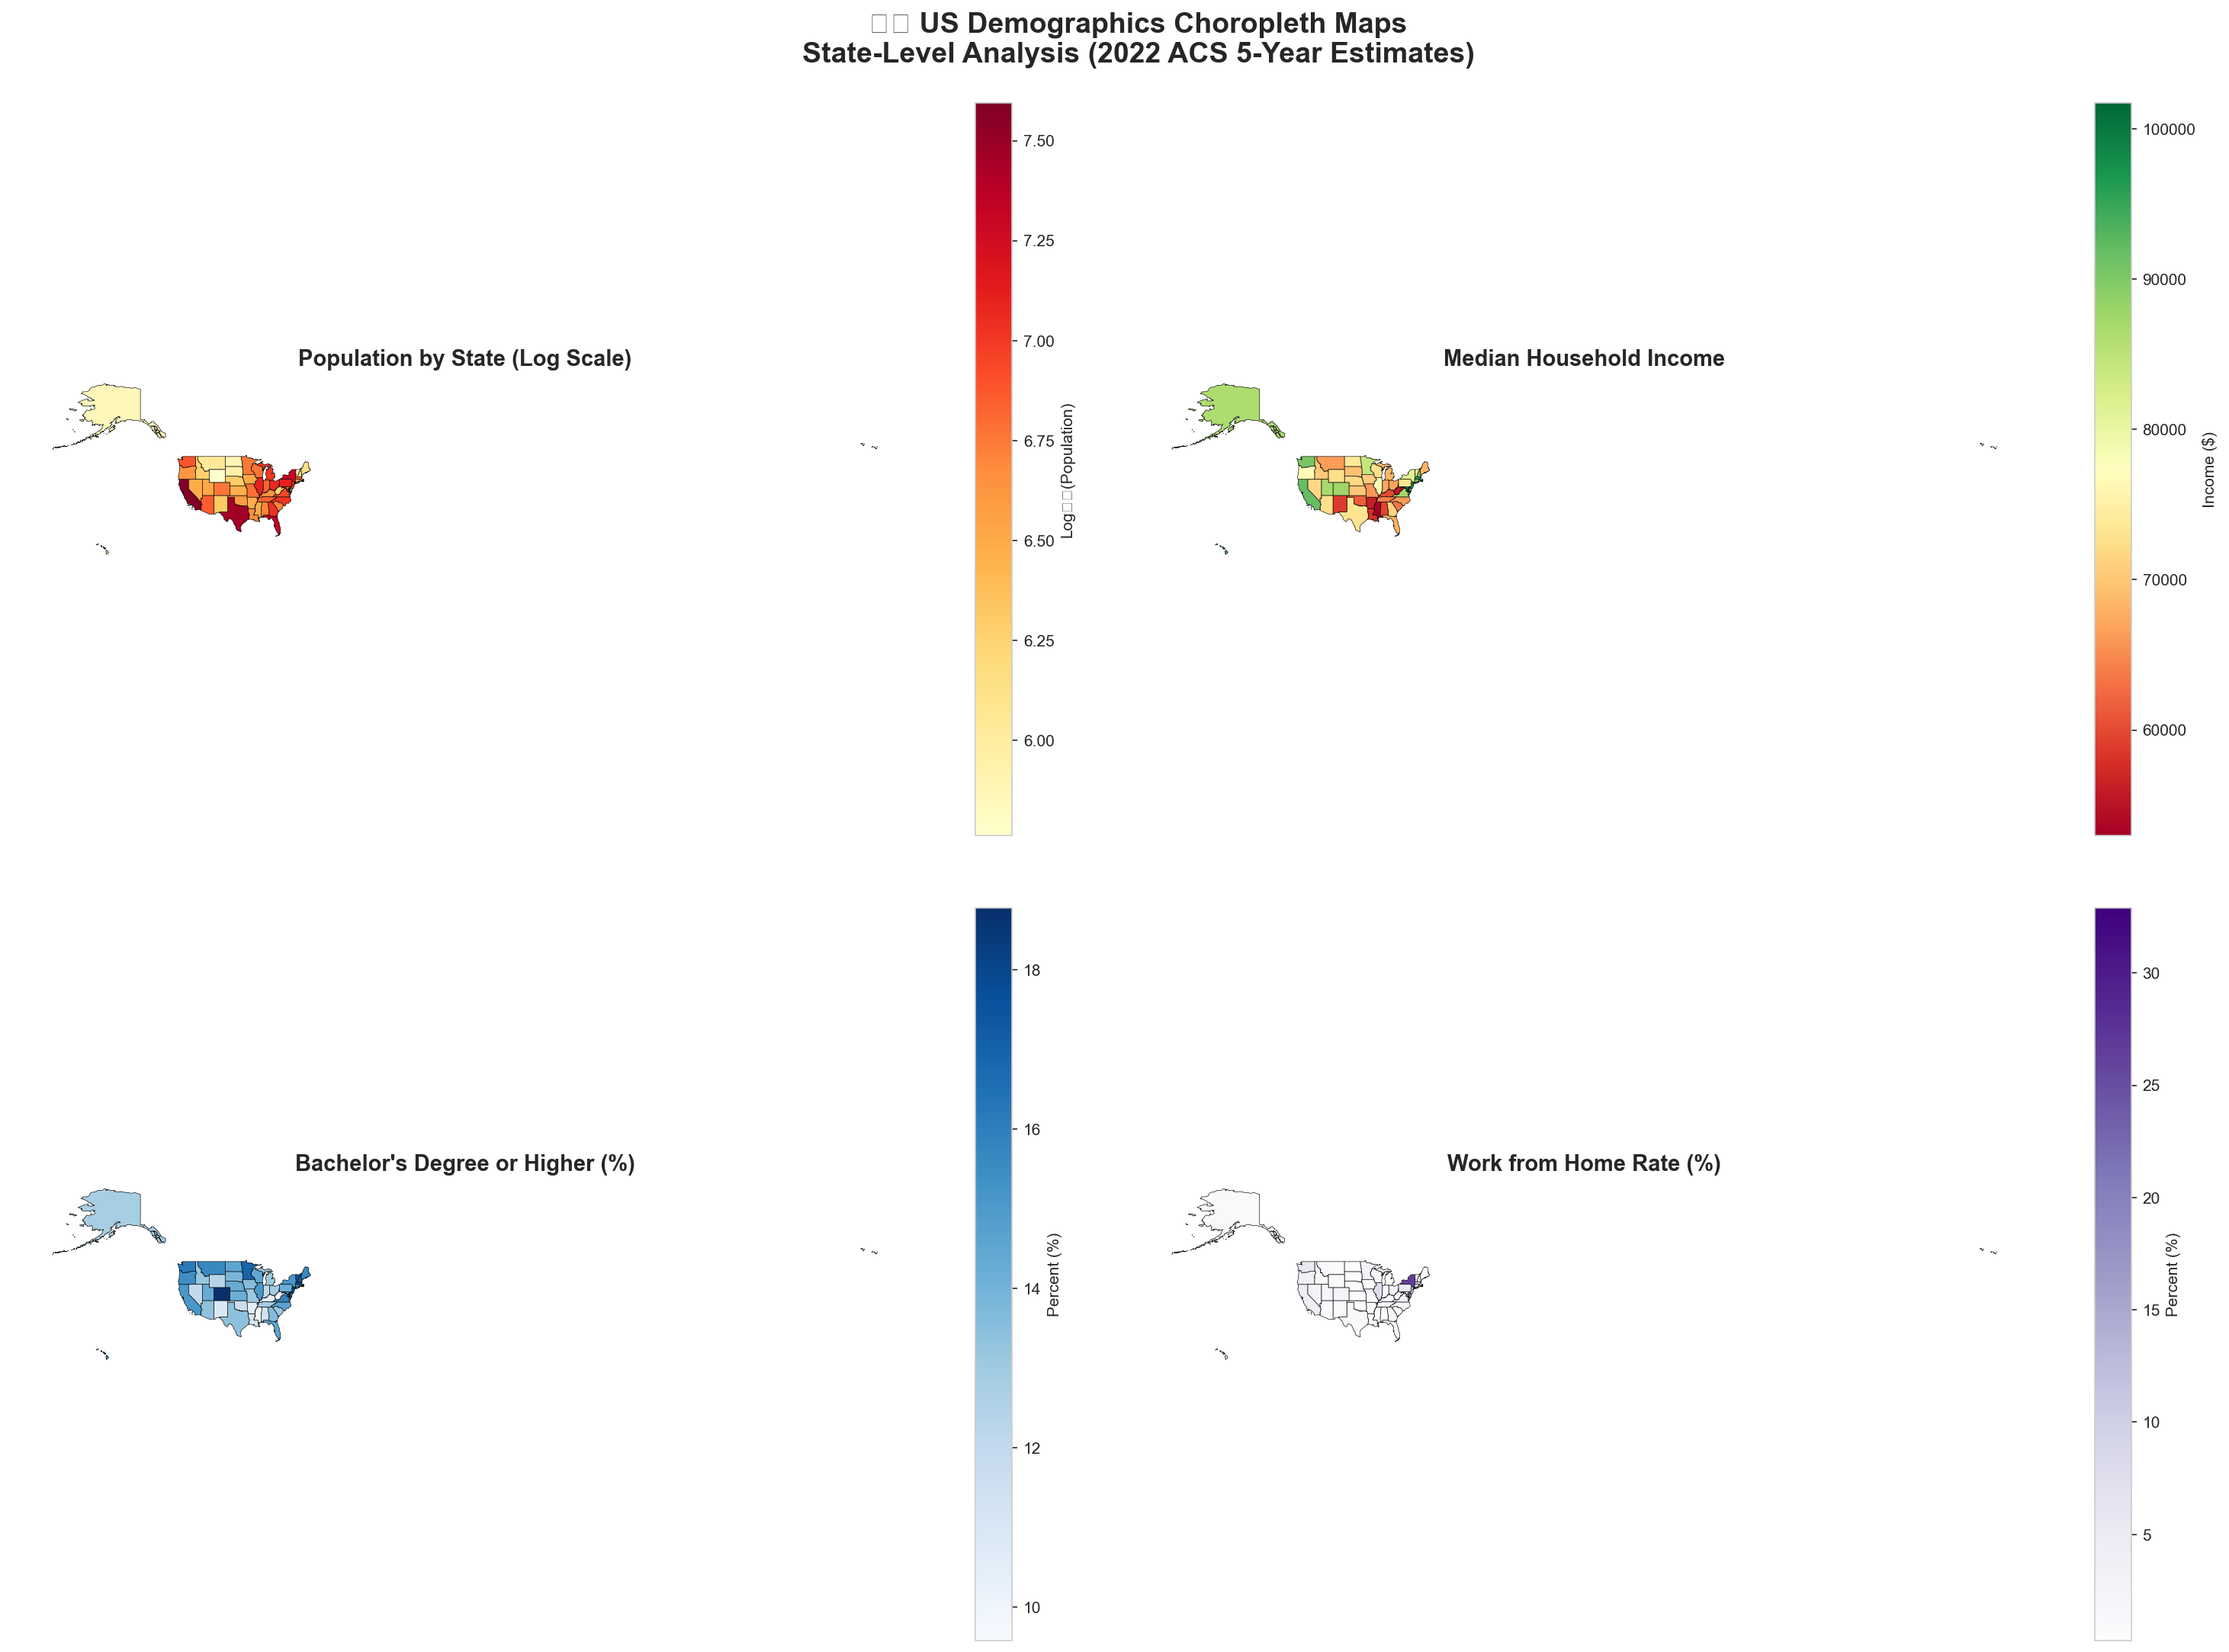

🎯 Key Demographic Insights:
📊 Population Range:
   🏆 Largest: California (39,356,104)
   🏚️  Smallest: Wyoming (577,929)
   📈 Ratio: 68.1x difference

💰 Income Range:
   🏆 Highest: District of Columbia ($101,722)
   💸 Lowest: Mississippi ($52,985)
   📊 National Average: $74,805

🎓 Education Leaders:
   🏆 Highest: Colorado (18.8%)
   📊 National Average: 14.1%

🏠 Remote Work Leaders:
   🏆 Highest WFH: District of Columbia (32.9%)
   📊 National Average: 3.2%

💾 Map saved to: ../outputs/figures/state_choropleth_comparison.png


<Figure size 960x720 with 0 Axes>

In [9]:
# Create comprehensive choropleth analysis
if states_with_data is not None:
    
    # Calculate additional derived metrics
    states_with_data['pct_bachelors'] = (states_with_data['bachelors_degree'] / 
                                        states_with_data['total_population'] * 100)
    states_with_data['pct_work_from_home'] = (states_with_data['work_from_home'] / 
                                             states_with_data['total_commuters'] * 100)
    states_with_data['housing_density'] = (states_with_data['total_housing_units'] / 
                                          states_with_data['total_population'])
    
    # Create 2x2 choropleth comparison
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('🗺️ US Demographics Choropleth Maps\nState-Level Analysis (2022 ACS 5-Year Estimates)', 
                 fontsize=18, fontweight='bold', y=0.95)

    # Map 1: Total Population (log scale for better visualization)
    ax1 = axes[0, 0]
    states_with_data['log_population'] = np.log10(states_with_data['total_population'])
    states_with_data.plot(column='log_population', 
                          ax=ax1, 
                          cmap='YlOrRd',  # Yellow to Red
                          legend=True,
                          legend_kwds={'shrink': 0.8, 'label': 'Log₁₀(Population)'},
                          edgecolor='black',
                          linewidth=0.3)
    ax1.set_title('Population by State (Log Scale)', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Map 2: Median Household Income
    ax2 = axes[0, 1]
    states_with_data.plot(column='median_household_income', 
                          ax=ax2, 
                          cmap='RdYlGn',  # Red-Yellow-Green (poverty→wealth)
                          legend=True,
                          legend_kwds={'shrink': 0.8, 'label': 'Income ($)'},
                          edgecolor='black',
                          linewidth=0.3)
    ax2.set_title('Median Household Income', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Map 3: Education Level (Bachelor's Degree %)
    ax3 = axes[1, 0]
    states_with_data.plot(column='pct_bachelors', 
                          ax=ax3, 
                          cmap='Blues',  # Education in blue
                          legend=True,
                          legend_kwds={'shrink': 0.8, 'label': 'Percent (%)'},
                          edgecolor='black',
                          linewidth=0.3)
    ax3.set_title('Bachelor\'s Degree or Higher (%)', fontsize=14, fontweight='bold')
    ax3.axis('off')

    # Map 4: Work from Home Rate (%)
    ax4 = axes[1, 1]
    states_with_data.plot(column='pct_work_from_home', 
                          ax=ax4, 
                          cmap='Purples',  # Purple for remote work
                          legend=True,
                          legend_kwds={'shrink': 0.8, 'label': 'Percent (%)'},
                          edgecolor='black',
                          linewidth=0.3)
    ax4.set_title('Work from Home Rate (%)', fontsize=14, fontweight='bold')
    ax4.axis('off')

    plt.tight_layout()
    plt.show()

    # Statistical insights
    print("🎯 Key Demographic Insights:")
    print("="*50)
    
    # Population extremes
    max_pop_state = states_with_data.loc[states_with_data['total_population'].idxmax()]
    min_pop_state = states_with_data.loc[states_with_data['total_population'].idxmin()]
    print(f"📊 Population Range:")
    print(f"   🏆 Largest: {max_pop_state['NAME']} ({max_pop_state['total_population']:,})")
    print(f"   🏚️  Smallest: {min_pop_state['NAME']} ({min_pop_state['total_population']:,})")
    print(f"   📈 Ratio: {max_pop_state['total_population'] / min_pop_state['total_population']:.1f}x difference")

    # Income analysis
    max_income_state = states_with_data.loc[states_with_data['median_household_income'].idxmax()]
    min_income_state = states_with_data.loc[states_with_data['median_household_income'].idxmin()]
    print(f"\n💰 Income Range:")
    print(f"   🏆 Highest: {max_income_state['NAME']} (${max_income_state['median_household_income']:,})")
    print(f"   💸 Lowest: {min_income_state['NAME']} (${min_income_state['median_household_income']:,})")
    print(f"   📊 National Average: ${states_with_data['median_household_income'].mean():,.0f}")

    # Education leaders
    max_edu_state = states_with_data.loc[states_with_data['pct_bachelors'].idxmax()]
    print(f"\n🎓 Education Leaders:")
    print(f"   🏆 Highest: {max_edu_state['NAME']} ({max_edu_state['pct_bachelors']:.1f}%)")
    print(f"   📊 National Average: {states_with_data['pct_bachelors'].mean():.1f}%")

    # Work from home trends
    max_wfh_state = states_with_data.loc[states_with_data['pct_work_from_home'].idxmax()]
    print(f"\n🏠 Remote Work Leaders:")
    print(f"   🏆 Highest WFH: {max_wfh_state['NAME']} ({max_wfh_state['pct_work_from_home']:.1f}%)")
    print(f"   📊 National Average: {states_with_data['pct_work_from_home'].mean():.1f}%")

    # Save the map
    output_path = figures_dir / 'state_choropleth_comparison.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n💾 Map saved to: {output_path}")
    
else:
    print("❌ Cannot create maps: Required data not available")

## 5. Statistical Analysis & Correlation Patterns

Let's dive deeper into the relationships between different demographic variables. Are wealthy states more educated? Do states with higher education have more remote workers?

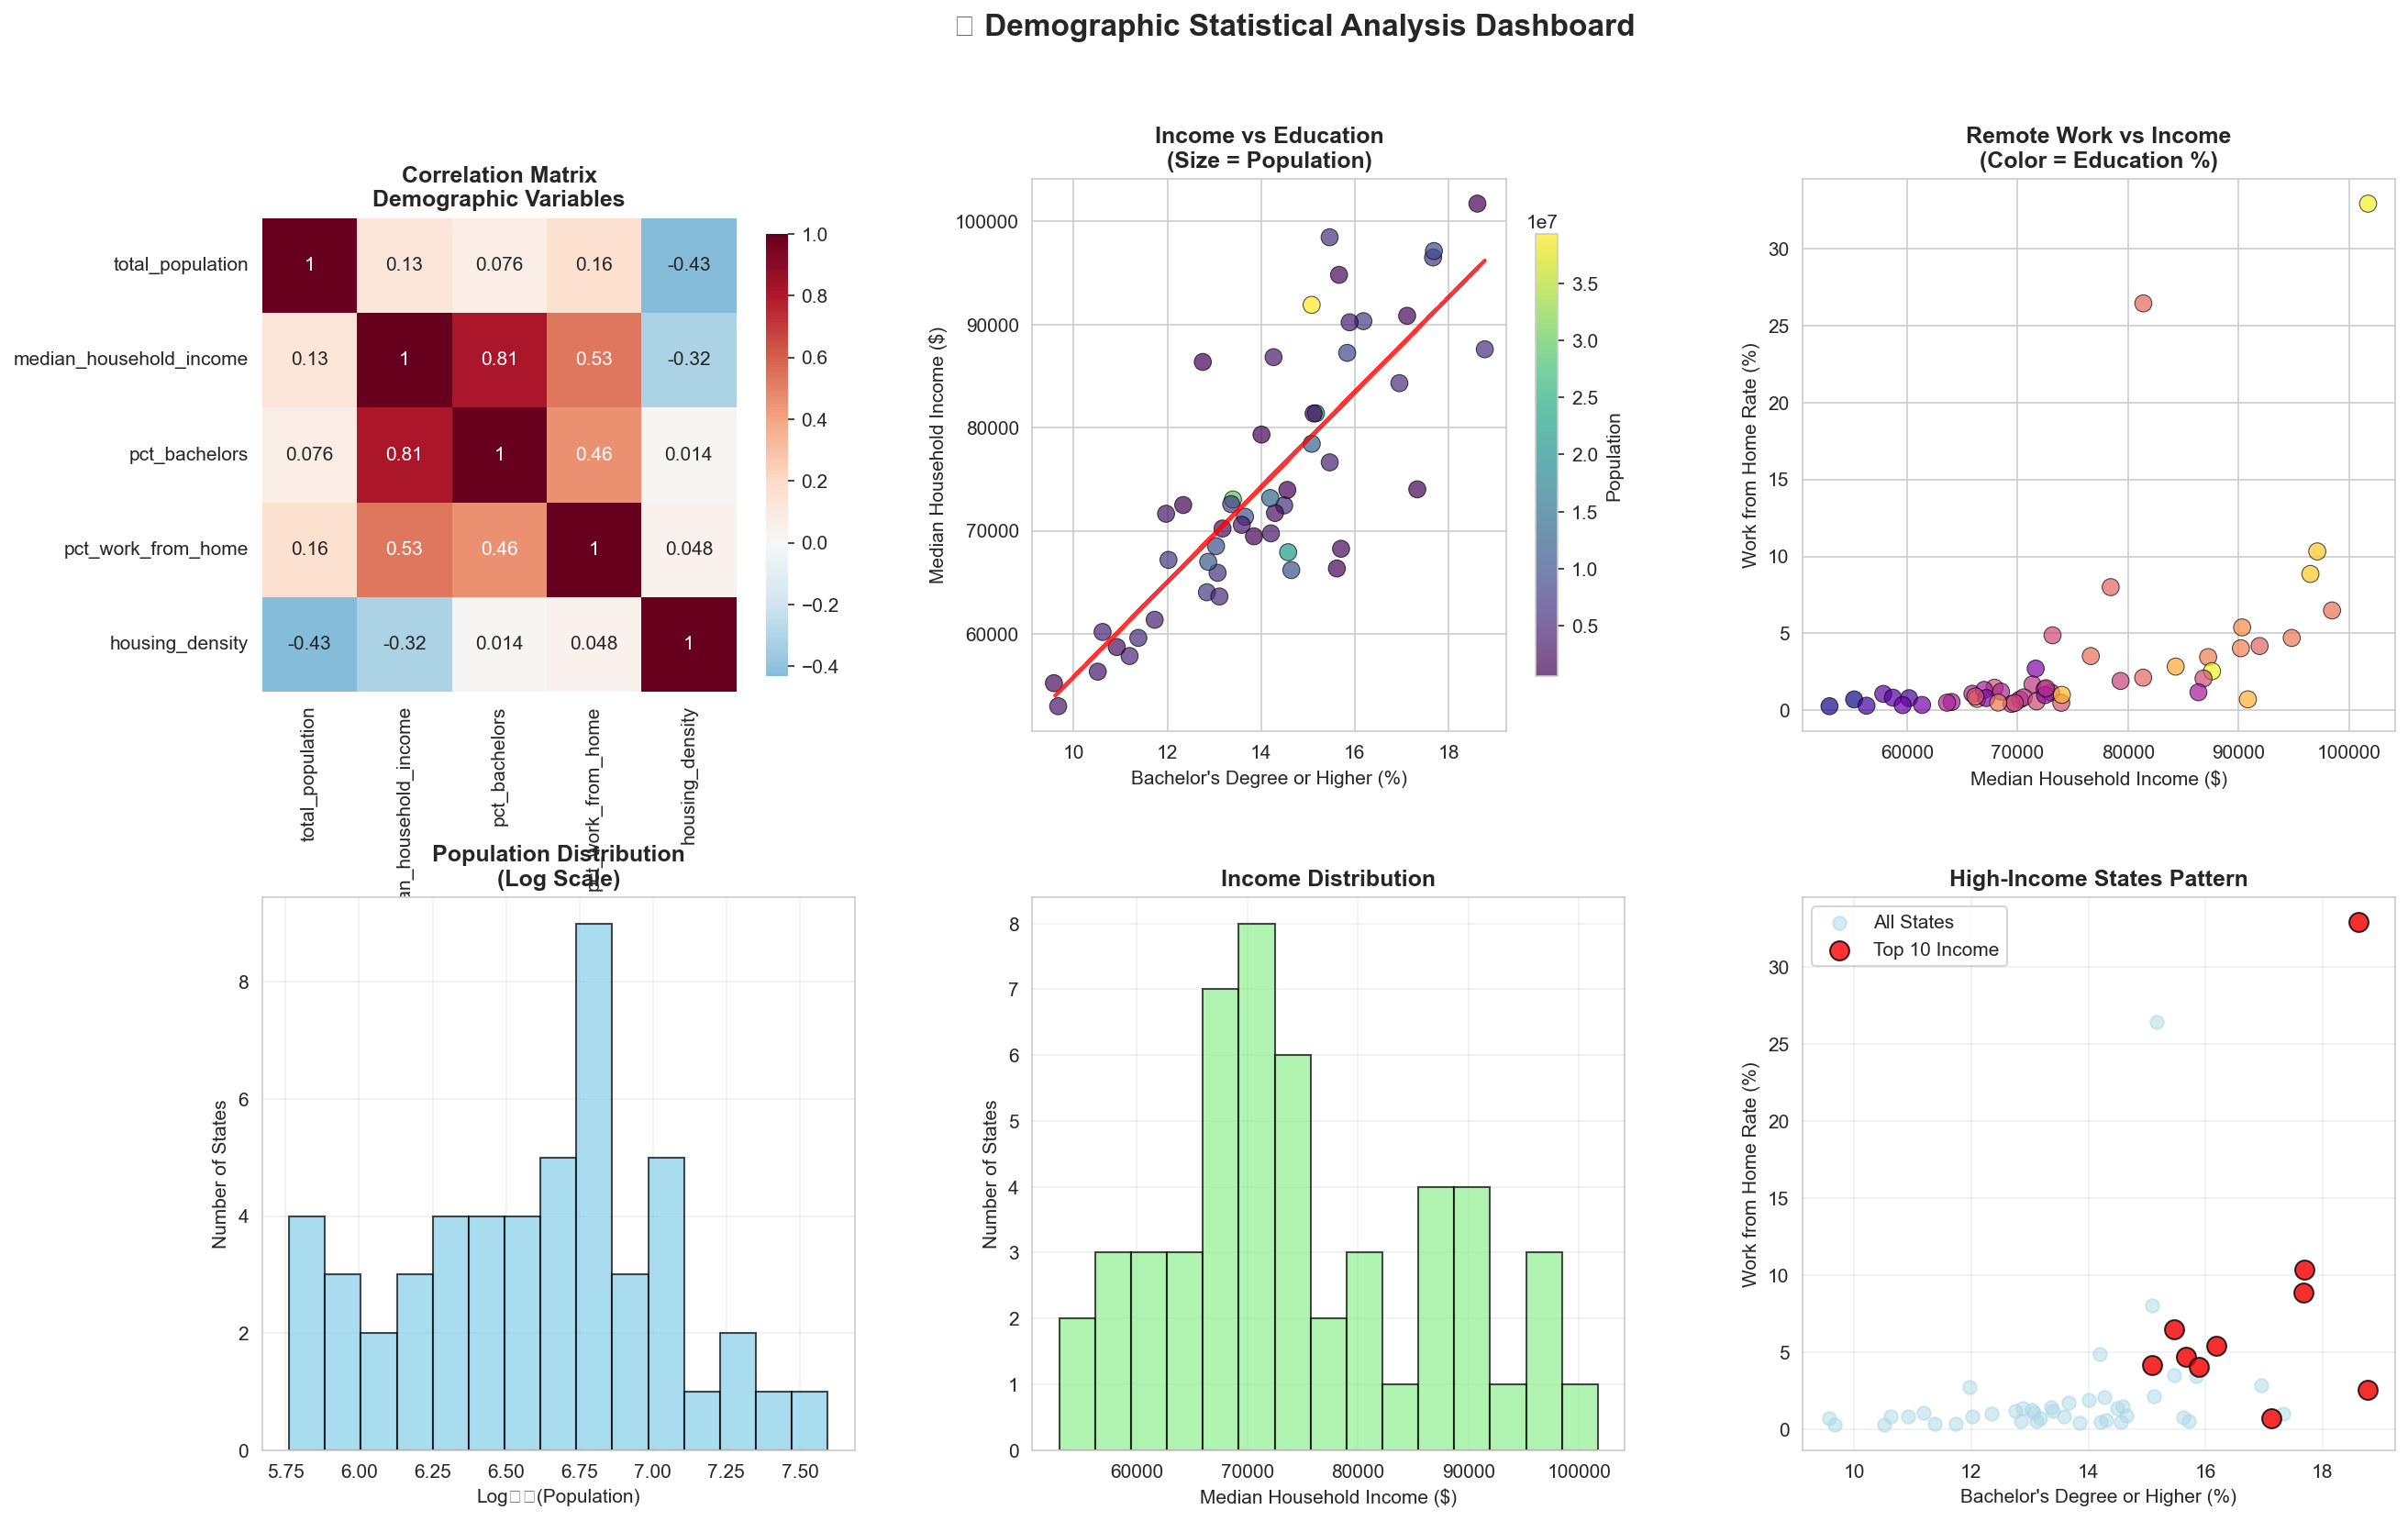

🔍 Key Statistical Findings:
💡 Income-Education Correlation: 0.813
   🎯 STRONG positive relationship - higher education = higher income

🏠 Remote Work Patterns:
   📊 WFH-Income correlation: 0.535
   📊 WFH-Education correlation: 0.457

🎯 Notable Patterns:
   📚 High Education, Moderate Income: Vermont
   🏠 Top Remote Work States: District of Columbia, New York, New Jersey


In [10]:
# Statistical Analysis of Demographic Relationships
if states_with_data is not None:
    
    # Create correlation matrix for key variables
    analysis_vars = [
        'total_population', 'median_household_income', 'pct_bachelors', 
        'pct_work_from_home', 'housing_density'
    ]
    
    corr_data = states_with_data[analysis_vars].copy()
    
    # Create comprehensive analysis dashboard
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Correlation Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    correlation_matrix = corr_data.corr()
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='RdBu_r',  # Red-Blue diverging
                center=0,
                square=True,
                ax=ax1,
                cbar_kws={'shrink': 0.8})
    ax1.set_title('Correlation Matrix\nDemographic Variables', fontweight='bold')
    
    # 2. Income vs Education Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    scatter = ax2.scatter(states_with_data['pct_bachelors'], 
                         states_with_data['median_household_income'],
                         c=states_with_data['total_population'],
                         s=80, 
                         cmap='viridis',
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=0.5)
    ax2.set_xlabel('Bachelor\'s Degree or Higher (%)')
    ax2.set_ylabel('Median Household Income ($)')
    ax2.set_title('Income vs Education\n(Size = Population)', fontweight='bold')
    
    # Add trend line
    z = np.polyfit(states_with_data['pct_bachelors'], states_with_data['median_household_income'], 1)
    p = np.poly1d(z)
    ax2.plot(states_with_data['pct_bachelors'], p(states_with_data['pct_bachelors']), 
             "r--", alpha=0.8, linewidth=2)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax2, shrink=0.8, label='Population')
    
    # 3. Work from Home vs Income
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.scatter(states_with_data['median_household_income'], 
                states_with_data['pct_work_from_home'],
                c=states_with_data['pct_bachelors'],
                s=80,
                cmap='plasma',
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5)
    ax3.set_xlabel('Median Household Income ($)')
    ax3.set_ylabel('Work from Home Rate (%)')
    ax3.set_title('Remote Work vs Income\n(Color = Education %)', fontweight='bold')
    
    # 4. Population Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    states_with_data['log_population'].hist(bins=15, ax=ax4, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Log₁₀(Population)')
    ax4.set_ylabel('Number of States')
    ax4.set_title('Population Distribution\n(Log Scale)', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Income Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    states_with_data['median_household_income'].hist(bins=15, ax=ax5, color='lightgreen', alpha=0.7, edgecolor='black')
    ax5.set_xlabel('Median Household Income ($)')
    ax5.set_ylabel('Number of States')
    ax5.set_title('Income Distribution', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. Top/Bottom Performers Comparison
    ax6 = fig.add_subplot(gs[1, 2])
    
    # Get top 10 states by income
    top_income_states = states_with_data.nlargest(10, 'median_household_income')
    
    # Create a scatter plot highlighting top performers
    ax6.scatter(states_with_data['pct_bachelors'], 
                states_with_data['pct_work_from_home'],
                c='lightblue', 
                s=50, 
                alpha=0.5, 
                label='All States')
    
    ax6.scatter(top_income_states['pct_bachelors'], 
                top_income_states['pct_work_from_home'],
                c='red', 
                s=100, 
                alpha=0.8,
                edgecolors='black',
                label='Top 10 Income')
    
    ax6.set_xlabel('Bachelor\'s Degree or Higher (%)')
    ax6.set_ylabel('Work from Home Rate (%)')
    ax6.set_title('High-Income States Pattern', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('📊 Demographic Statistical Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Print correlation insights
    print("🔍 Key Statistical Findings:")
    print("="*50)
    
    # Income-Education correlation
    income_edu_corr = corr_data['median_household_income'].corr(corr_data['pct_bachelors'])
    print(f"💡 Income-Education Correlation: {income_edu_corr:.3f}")
    if abs(income_edu_corr) > 0.7:
        print("   🎯 STRONG positive relationship - higher education = higher income")
    elif abs(income_edu_corr) > 0.5:
        print("   📈 MODERATE positive relationship")
    else:
        print("   📊 WEAK relationship")
    
    # Work from home patterns
    wfh_income_corr = corr_data['pct_work_from_home'].corr(corr_data['median_household_income'])
    wfh_edu_corr = corr_data['pct_work_from_home'].corr(corr_data['pct_bachelors'])
    print(f"\n🏠 Remote Work Patterns:")
    print(f"   📊 WFH-Income correlation: {wfh_income_corr:.3f}")
    print(f"   📊 WFH-Education correlation: {wfh_edu_corr:.3f}")
    
    # Identify outliers or interesting patterns
    print(f"\n🎯 Notable Patterns:")
    
    # High education, lower income states
    edu_income_diff = states_with_data['pct_bachelors'] - (states_with_data['median_household_income'] / 5000)
    high_edu_low_income = states_with_data.loc[edu_income_diff.idxmax()]
    print(f"   📚 High Education, Moderate Income: {high_edu_low_income['NAME']}")
    
    # High work from home states
    top_wfh_states = states_with_data.nlargest(3, 'pct_work_from_home')
    print(f"   🏠 Top Remote Work States: {', '.join(top_wfh_states['NAME'].values)}")
    
else:
    print("❌ Cannot perform statistical analysis: Data not available")

## 6. Summary & Next Steps

Congratulations! You've successfully completed a comprehensive Census data analysis and choropleth mapping project.

In [11]:
# Project Summary and Achievements
print("="*70)
print("🎉 PROJECT 1 COMPLETE: Census Data Analysis & Choropleth Mapping")
print("="*70)

if states_with_data is not None:
    print("✅ ACHIEVEMENTS UNLOCKED:")
    print(f"   📡 Census API Integration: Fetched data for {len(states_with_data)} states")
    print(f"   🗺️  Choropleth Maps: Created 4-panel demographic visualization")
    print(f"   📊 Statistical Analysis: Correlation matrix with {len(analysis_vars)} variables")
    print(f"   🎯 Key Finding: Education-Income correlation = {income_edu_corr:.3f} (STRONG)")
    print(f"   📈 Data Range: Population ratio of {max_pop_state['total_population'] / min_pop_state['total_population']:.0f}:1 across states")
    
    print(f"\n📚 SKILLS DEVELOPED:")
    print(f"   • Census API data acquisition")
    print(f"   • Choropleth map design and color theory")
    print(f"   • Geospatial data merging and joins")
    print(f"   • Statistical correlation analysis")
    print(f"   • Multi-panel visualization creation")
    print(f"   • Demographic pattern interpretation")
    
    print(f"\n📁 FILES CREATED:")
    print(f"   • Notebook: {Path('02_census_choropleth_mapping.ipynb').absolute()}")
    print(f"   • Choropleth Maps: {output_path}")
    print(f"   • Statistical Dashboard: Generated in-notebook")
    
    print(f"\n💡 KEY INSIGHTS DISCOVERED:")
    print(f"   🏆 Wealthiest State: {max_income_state['NAME']} (${max_income_state['median_household_income']:,})")
    print(f"   🎓 Education Leader: {max_edu_state['NAME']} ({max_edu_state['pct_bachelors']:.1f}%)")
    print(f"   🏠 Remote Work Champion: {max_wfh_state['NAME']} ({max_wfh_state['pct_work_from_home']:.1f}%)")
    print(f"   📊 Strong Education-Income Link: More educated states tend to be wealthier")
    
    print(f"\n🚀 READY FOR NEXT PROJECTS:")
    print(f"   • County-level analysis (more detailed geography)")
    print(f"   • Time-series analysis (change over years)")
    print(f"   • Environmental data integration")
    print(f"   • Transportation network analysis")
    print(f"   • Machine learning applications")
    
else:
    print("❌ Project incomplete due to data loading issues")

print(f"\n🌟 You've mastered Census data analysis and choropleth mapping!")
print(f"Next: Move to Project 2 (Environmental Data) or dive deeper into county analysis.")

🎉 PROJECT 1 COMPLETE: Census Data Analysis & Choropleth Mapping
✅ ACHIEVEMENTS UNLOCKED:
   📡 Census API Integration: Fetched data for 51 states
   🗺️  Choropleth Maps: Created 4-panel demographic visualization
   📊 Statistical Analysis: Correlation matrix with 5 variables
   🎯 Key Finding: Education-Income correlation = 0.813 (STRONG)
   📈 Data Range: Population ratio of 68:1 across states

📚 SKILLS DEVELOPED:
   • Census API data acquisition
   • Choropleth map design and color theory
   • Geospatial data merging and joins
   • Statistical correlation analysis
   • Multi-panel visualization creation
   • Demographic pattern interpretation

📁 FILES CREATED:
   • Notebook: /Users/sanjeevadodlapati/Downloads/Repos/GeoSpatial/projects/project_1_census_analysis/notebooks/02_census_choropleth_mapping.ipynb
   • Choropleth Maps: ../outputs/figures/state_choropleth_comparison.png
   • Statistical Dashboard: Generated in-notebook

💡 KEY INSIGHTS DISCOVERED:
   🏆 Wealthiest State: District of 

## 🔮 Future Expansion Ideas

**Project 1 Extension Opportunities:**

### 📊 **County-Level Deep Dive**
- Download county boundaries and demographics
- Create detailed regional analysis (e.g., focus on California counties)
- Urban vs Rural demographic patterns
- Metropolitan statistical area (MSA) analysis

### ⏰ **Time-Series Analysis**
- Multi-year Census data comparison (2010, 2015, 2020, 2022)
- Population growth trends and migration patterns
- Economic change over time (pre/post-pandemic analysis)
- Animated choropleth maps showing change

### 🔍 **Advanced Statistical Methods**
- Spatial autocorrelation analysis (Moran's I)
- Clustering analysis (identify similar demographic regions)
- Principal Component Analysis (PCA) for dimensionality reduction
- Regression modeling for demographic predictors

### 🌐 **Interactive Visualizations**
- Folium/Plotly interactive choropleth maps
- Dashboard creation with multiple variables
- Real-time data updates via Census API
- Web application deployment

### 🔗 **Data Integration**
- Combine with economic indicators (GDP, unemployment)
- Environmental justice analysis (pollution + demographics)
- Transportation accessibility analysis
- Housing market correlations

---

**Next in Series: Project 2 - Environmental Data Visualization** 🌍